# Read in netcdfs, and plot results

## should put stats in another notebook or make it into a function at least

In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
# import climtas # needed to count event statistics with a specified duration
import seaborn as sns
import scipy.stats # to calculate correlation

In [2]:
# import custom functions
import sys 
# sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook
sys.path.append('/g/data/w48/kb6999/Functions') # use this if the function file is in a different directory to the notebook


import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

In [3]:
import dask.distributed
import tempfile

tempdir = tempfile.TemporaryDirectory("dask-worker-space")
dask.distributed.Client(local_directory=tempdir.name, memory_limit='16gb')

Client Scheduler: tcp://127.0.0.1:35461 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


## Open datasets of means and percentiles for plotting

In [4]:
path_R = '/g/data/w48/kb6999/Reanalysis/'

In [5]:
# open the observational dataset CRUT. which has rainfall over land
# it has monthly anomalies relative to a 1961-1990 climatology 
# cru_ts4 = xr.open_dataset('/home/563/kb6999/cru_ts4.05.1901.2020.pre.dat.nc')
cru_ts4 = xr.open_dataset(f'{path_R}cru_ts4.05.1901.2020.pre.dat.nc.gz')
# # rename lat and lon coords and select out time so same as 20CR
# cru_ts4 = cru_ts4.rename({'latitude': 'lat', 'longitude': 'lon'}).sel(time=slice('1850','2015'))
cru_ts4

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 1440)
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16
Data variables:
    pre      (time, lat, lon) float32 ...
    stn      (time, lat, lon) float64 ...
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.05 Precipitation
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2103051243. Data generated from:pre.2103041709.dtb
    history:      Fri  5 Mar 14:41:58 GMT 2021 : User harry : Program makegri...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk

In [6]:
cru_ts4 = xr.Dataset({'pr': cru_ts4.pre})
# convert to mm/day (from mm/month)
cru_ts4['pr'] = cru_ts4.pr/30.4167
cru_ts4

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 1440)
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16
Data variables:
    pr       (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [7]:
# take the anomaly fro cru ts based on a climatology of 1900-1930
cru_ts4_anom = func.monthly_anomaly(cru_ts4, '1900-01', '1930-01')

In [8]:
# area weighting
cru_ts4_glob = cru_ts4_anom*np.cos(cru_ts4_anom.lat*(np.pi/180))
cru_ts4_glob

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 1440)
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    pr       (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

## Note that I haven't used a landmask for Aus and EA this time!! but id on't need to cos theree's only data over land anyway

In [9]:
# Select out SH and NH anomalies 
cru_ts4_SH = cru_ts4_glob.sel(lat=slice(-90,0)) 
cru_ts4_NH = cru_ts4_glob.sel(lat=slice(0,90)) 
# select out the Australian and E Australian anomalies 
cru_ts4_Aus = cru_ts4_glob.sel(lat=slice(-50,-10), lon=slice(110,160))#.where(landmask.LAND==1.0, drop=True)
cru_ts4_EA = cru_ts4_glob.sel(lat=slice(-50,-10), lon=slice(140,155))#.where(landmask.LAND==1.0, drop=True)
cru_ts4_EA

<xarray.Dataset>
Dimensions:  (lat: 80, lon: 30, time: 1440)
Coordinates:
  * lon      (lon) float32 140.2 140.8 141.2 141.8 ... 153.2 153.8 154.2 154.8
  * lat      (lat) float32 -49.75 -49.25 -48.75 -48.25 ... -11.25 -10.75 -10.25
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    pr       (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [10]:
# take the llm of cru ts anomaly
cru_ts4_llm_glob = cru_ts4_glob.pr.mean(dim=['lat','lon'])
cru_ts4_llm_SH = cru_ts4_SH.pr.mean(dim=['lat','lon'])
cru_ts4_llm_Aus = cru_ts4_Aus.pr.mean(dim=['lat','lon'])
cru_ts4_llm_EA = cru_ts4_EA.pr.mean(dim=['lat','lon'])

# 20CR data

In [11]:
path = '/g/data/w48/kb6999/Reanalysis/20CR_PRATE_data_for_plots/'

In [12]:
# open lat lon mean of temperature 
llm_Glob = xr.open_dataset(f'{path}llm_pr_Glob.nc')
llm_NH = xr.open_dataset(f'{path}llm_pr_NH.nc')
llm_SH = xr.open_dataset(f'{path}llm_pr_SH.nc')
llm_Aus = xr.open_dataset(f'{path}llm_pr_Aus.nc')
llm_EA = xr.open_dataset(f'{path}llm_pr_EA.nc')

In [13]:
# open multi member mean of temperature
mmm_mon_Glob = xr.open_dataset(f'{path}mmm_mon_pr_Glob.nc')
mmm_mon_NH = xr.open_dataset(f'{path}mmm_mon_pr_NH.nc')
mmm_mon_SH = xr.open_dataset(f'{path}mmm_mon_pr_SH.nc')
mmm_mon_Aus = xr.open_dataset(f'{path}mmm_mon_pr_Aus.nc')
mmm_mon_EA = xr.open_dataset(f'{path}mmm_mon_pr_EA.nc')

In [14]:
# mmm_mon_Glob_land = xr.open_dataset(f'{path}mmm_mon_Glob_land_v2.nc')
mmm_mon_SH_land = xr.open_dataset(f'{path}mmm_mon_SH_land.nc')

In [15]:
# open percentile data for land
p10_mon_Glob_land = xr.open_dataset(f'{path}p10_mon_Glob_land.nc') # all good 
# p10_mon_SH_land = xr.open_dataset(f'{path}p10_mon_SH_land.nc') # did not work! 
# p90
# p90_mon_Glob_land = xr.open_dataset(f'{path}p90_mon_Glob_land.nc') # did not work properly 
# p90_mon_SH_land = xr.open_dataset(f'{path}p90_mon_SH_land.nc') # did not work! 

In [16]:
# p90_mon_Glob_land.pr.plot()

In [17]:
# open percentile data for temperature
p10_mon_Glob = xr.open_dataset(f'{path}p10_mon_pr_Glob.nc')
p10_mon_NH = xr.open_dataset(f'{path}p10_mon_pr_NH.nc')
p10_mon_SH = xr.open_dataset(f'{path}p10_mon_pr_SH.nc')
p10_mon_Aus = xr.open_dataset(f'{path}p10_mon_pr_Aus.nc')
p10_mon_EA = xr.open_dataset(f'{path}p10_mon_pr_EA.nc')

In [18]:
# open percentile data for temperature
p90_mon_Glob = xr.open_dataset(f'{path}p90_mon_pr_Glob.nc')
p90_mon_NH = xr.open_dataset(f'{path}p90_mon_pr_NH.nc')
p90_mon_SH = xr.open_dataset(f'{path}p90_mon_pr_SH.nc')
p90_mon_Aus = xr.open_dataset(f'{path}p90_mon_pr_Aus.nc')
p90_mon_EA = xr.open_dataset(f'{path}p90_mon_pr_EA.nc')

### select out Krakatoa years 

In [19]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

In [20]:
# save arrays of times relative to each eruption
e_pre5yrs = e_date - 60 * pd.offsets.MonthBegin()
e_pre3mon = e_date - 3 * pd.offsets.MonthBegin()
e_post5yrs = e_date + 61 * pd.offsets.MonthBegin()
e_post10yrs = e_date + 121 * pd.offsets.MonthBegin()

In [21]:
# Zoom in on Krakatoa time period
K_mmm_Glob = mmm_mon_Glob.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_SH = mmm_mon_SH.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_Aus = mmm_mon_Aus.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_EA = mmm_mon_EA.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p10_Glob = p10_mon_Glob.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_SH = p10_mon_SH.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_Aus = p10_mon_Aus.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_EA = p10_mon_EA.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p90_Glob = p90_mon_Glob.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_SH = p90_mon_SH.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_Aus = p90_mon_Aus.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_EA = p90_mon_EA.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

## Figures

In [22]:
# set the default font size
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [23]:
# use this to set the x-ticks for each month from 5 years before to 5 years after the eruption
months = pd.date_range(e_pre5yrs[0], e_post5yrs[0], freq='MS')
years = pd.date_range(e_pre5yrs[0], e_post5yrs[0], freq='YS')

In [ ]:
# Monthly rainfall anomalies stacked
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    fplot.timeseries_graph(mmm_mon_Glob.pr, p10_mon_Glob.pr, p90_mon_Glob.pr, ax = axes[0], color='mediumaquamarine')
    fplot.timeseries_graph(mmm_mon_SH.pr, p10_mon_SH.pr, p90_mon_SH.pr, ax = axes[1], color='mediumaquamarine')
    fplot.timeseries_graph(mmm_mon_Aus.pr, p10_mon_Aus.pr, p90_mon_Aus.pr, ax = axes[2], color='mediumaquamarine')
    fplot.timeseries_graph(mmm_mon_EA.pr, p10_mon_EA.pr, p90_mon_EA.pr, ax = axes[3], color='mediumaquamarine')

axes[0].set(ylabel= f'Rainfall anomaly [mm/day]', title = 'Global') 
axes[1].set(ylabel= f'Rainfall anomaly [mm/day]', title = 'Southern Hemisphere')
axes[2].set(ylabel= f'Rainfall anomaly [mm/day]', title = 'Australia')
axes[3].set(ylabel= f'Rainfall anomaly [mm/day]', title = 'Eastern Australia')

#fig.suptitle('Time series of temperature anomalies', size=16)

#fig.tight_layout() # makes titles overlap, but is meant to stops things from overlapping and makes the figure more compact

plt.savefig('R_timeseries_mon_pr_stacked.png', dpi=300, bbox_inches='tight')

In [ ]:
# Monthly rainfall anomalies for Krakatoa
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10)) # make a figure

# make subplots for each region
fplot.timeseries_graph(K_mmm_Glob.pr, K_p10_Glob.pr, K_p90_Glob.pr, ax = axes[0,0], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_SH.pr, K_p10_SH.pr, K_p90_SH.pr, ax = axes[0,1], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_Aus.pr, K_p10_Aus.pr, K_p90_Aus.pr, ax = axes[1,0], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_EA.pr, K_p10_EA.pr, K_p90_EA.pr, ax = axes[1,1], color='mediumaquamarine')

# set axis labels and subplot titles
axes[0,0].set(ylabel= f'Rainfall anomaly [mm/day]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel= f'Rainfall anomaly [mm/day]', title = 'Australia')
axes[1,1].set(title = 'Eastern Australia')

# set the axis ticks to be monthly 
axes[0,0].set_xticks(years)
axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('R_K_timeseries_mon_pr.png', dpi=300, bbox_inches='tight')

## Analysis using Rolling mean 

In [24]:
# calculate rolling means of lat lon data
llm_mon_Glob_roll6 = llm_Glob.rolling(time=6).mean()
llm_mon_NH_roll6 = llm_NH.rolling(time=6).mean()
llm_mon_SH_roll6 = llm_SH.rolling(time=6).mean()
llm_mon_Aus_roll6 = llm_Aus.rolling(time=6).mean()
llm_mon_EA_roll6 = llm_EA.rolling(time=6).mean()

In [25]:
# calculate rolling means
mmm_mon_Glob_roll6 = mmm_mon_Glob.rolling(time=6).mean()
mmm_mon_NH_roll6 = mmm_mon_NH.rolling(time=6).mean()
mmm_mon_SH_roll6 = mmm_mon_SH.rolling(time=6).mean()
mmm_mon_Aus_roll6 = mmm_mon_Aus.rolling(time=6).mean()
mmm_mon_EA_roll6 = mmm_mon_EA.rolling(time=6).mean()

In [26]:
# calculate rolling means
p10_mon_Glob_roll6 = p10_mon_Glob.rolling(time=6).mean()
p10_mon_NH_roll6 = p10_mon_NH.rolling(time=6).mean()
p10_mon_SH_roll6 = p10_mon_SH.rolling(time=6).mean()
p10_mon_Aus_roll6 = p10_mon_Aus.rolling(time=6).mean()
p10_mon_EA_roll6 = p10_mon_EA.rolling(time=6).mean()

In [27]:
# calculate rolling means
p90_mon_Glob_roll6 = p90_mon_Glob.rolling(time=6).mean()
p90_mon_NH_roll6 = p90_mon_NH.rolling(time=6).mean()
p90_mon_SH_roll6 = p90_mon_SH.rolling(time=6).mean()
p90_mon_Aus_roll6 = p90_mon_Aus.rolling(time=6).mean()
p90_mon_EA_roll6 = p90_mon_EA.rolling(time=6).mean()

In [28]:
# 3 month rolling mean and percentiles
mmm_mon_Glob_roll3 = mmm_mon_Glob.rolling(time=3).mean()
mmm_mon_Aus_roll3 = mmm_mon_Aus.rolling(time=3).mean()

p10_mon_Glob_roll3 = p10_mon_Glob.rolling(time=3).mean()
p10_mon_Aus_roll3 = p10_mon_Aus.rolling(time=3).mean()

p90_mon_Glob_roll3 = p90_mon_Glob.rolling(time=3).mean()
p90_mon_Aus_roll3 = p90_mon_Aus.rolling(time=3).mean()

# 12 month rolling mean and percentiles for all 4 regions
mmm_mon_Glob_roll12 = mmm_mon_Glob.rolling(time=12).mean()
mmm_mon_SH_roll12 = mmm_mon_SH.rolling(time=12).mean()
mmm_mon_Aus_roll12 = mmm_mon_Aus.rolling(time=12).mean()
mmm_mon_EA_roll12 = mmm_mon_EA.rolling(time=12).mean()

p10_mon_Glob_roll12 = p10_mon_Glob.rolling(time=12).mean()
p10_mon_SH_roll12 = p10_mon_SH.rolling(time=12).mean()
p10_mon_Aus_roll12 = p10_mon_Aus.rolling(time=12).mean()
p10_mon_EA_roll12 = p10_mon_EA.rolling(time=12).mean()

p90_mon_Glob_roll12 = p90_mon_Glob.rolling(time=12).mean()
p90_mon_SH_roll12 = p90_mon_SH.rolling(time=12).mean()
p90_mon_Aus_roll12 = p90_mon_Aus.rolling(time=12).mean()
p90_mon_EA_roll12 = p90_mon_EA.rolling(time=12).mean()

# 24 month rolling mean and percentiles 
mmm_mon_Glob_roll24 = mmm_mon_Glob.rolling(time=24).mean()
mmm_mon_Aus_roll24 = mmm_mon_Aus.rolling(time=24).mean()

p10_mon_Glob_roll24 = p10_mon_Glob.rolling(time=24).mean()
p10_mon_Aus_roll24 = p10_mon_Aus.rolling(time=24).mean()

p90_mon_Glob_roll24 = p90_mon_Glob.rolling(time=24).mean()
p90_mon_Aus_roll24 = p90_mon_Aus.rolling(time=24).mean()


In [29]:
# take the rolling mean of land data
# mmm_mon_Glob_land_roll12 = mmm_mon_Glob_land.rolling(time=12).mean()
mmm_mon_SH_land_roll12 = mmm_mon_SH_land.rolling(time=12).mean()

In [30]:
# take rolling mean of cru data
cru_ts4_llm_glob_roll12 = cru_ts4_llm_glob.rolling(time=12).mean()
cru_ts4_llm_SH_roll12 = cru_ts4_llm_SH.rolling(time=12).mean()
cru_ts4_llm_Aus_roll12 = cru_ts4_llm_Aus.rolling(time=12).mean()
cru_ts4_llm_EA_roll12 = cru_ts4_llm_EA.rolling(time=12).mean()

## Rolling mean

In [31]:
# take time slice for years data overlaps 1900-01 to 2015-01
start_date, end_date = '1900-01','2015-01'
# mmm_mon_Glob_land_roll12_t = mmm_mon_Glob_land_roll12.sel(time=slice(start_date, end_date))
mmm_mon_SH_land_roll12_t = mmm_mon_SH_land_roll12.sel(time=slice(start_date, end_date))

mmm_mon_Glob_roll12_t = mmm_mon_Glob_roll12.sel(time=slice(start_date, end_date))
mmm_mon_SH_roll12_t = mmm_mon_SH_roll12.sel(time=slice(start_date, end_date))
mmm_mon_Aus_roll12_t = mmm_mon_Aus_roll12.sel(time=slice(start_date, end_date))
mmm_mon_EA_roll12_t = mmm_mon_EA_roll12.sel(time=slice(start_date, end_date))

p10_mon_Glob_roll12_t = p10_mon_Glob_roll12.sel(time=slice(start_date, end_date))
p10_mon_SH_roll12_t = p10_mon_SH_roll12.sel(time=slice(start_date, end_date))
p10_mon_Aus_roll12_t = p10_mon_Aus_roll12.sel(time=slice(start_date, end_date))
p10_mon_EA_roll12_t = p10_mon_EA_roll12.sel(time=slice(start_date, end_date))

p90_mon_Glob_roll12_t = p90_mon_Glob_roll12.sel(time=slice(start_date, end_date))
p90_mon_SH_roll12_t = p90_mon_SH_roll12.sel(time=slice(start_date, end_date))
p90_mon_Aus_roll12_t = p90_mon_Aus_roll12.sel(time=slice(start_date, end_date))
p90_mon_EA_roll12_t = p90_mon_EA_roll12.sel(time=slice(start_date, end_date))

### with global land only and SH land only

NameError: name 'mmm_mon_Glob_land_roll12_t' is not defined

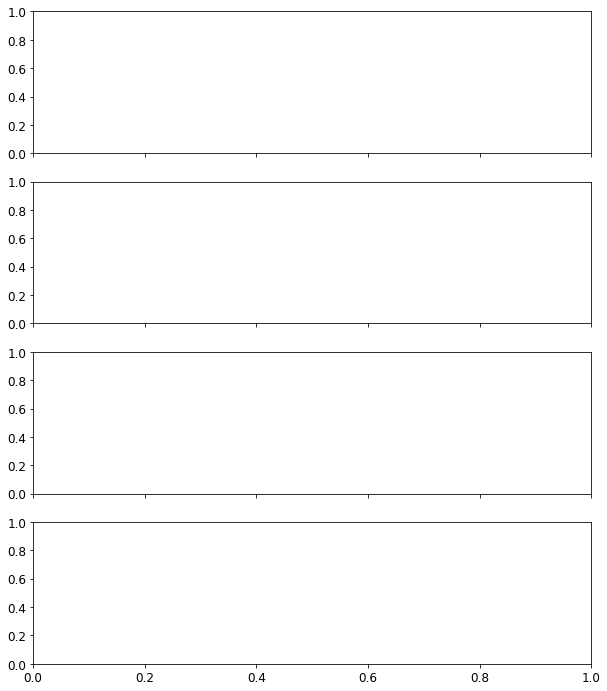

In [32]:
# Monthly rainfall anomalies stacked - rolling mean
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    fplot.timeseries_graph(mmm_mon_Glob_land_roll12_t.pr, p10_mon_Glob_roll12_t.pr, p90_mon_Glob_roll12_t.pr, ax = axes[0], color='mediumaquamarine', l='20CR', label='20CR percentiles')
    fplot.timeseries_graph(mmm_mon_SH_land_roll12_t.pr, p10_mon_SH_roll12_t.pr, p90_mon_SH_roll12_t.pr, ax = axes[1], color='mediumaquamarine')
    fplot.timeseries_graph(mmm_mon_Aus_roll12_t.pr, p10_mon_Aus_roll12_t.pr, p90_mon_Aus_roll12_t.pr, ax = axes[2], color='mediumaquamarine')
    fplot.timeseries_graph(mmm_mon_EA_roll12_t.pr, p10_mon_EA_roll12_t.pr, p90_mon_EA_roll12_t.pr, ax = axes[3], color='mediumaquamarine')
    
cru_ts4_llm_glob_roll12.sel(time=slice(start_date, end_date)).plot(ax=axes[0], color='coral',label='CRU TS 4.05')
cru_ts4_llm_SH_roll12.sel(time=slice(start_date, end_date)).plot(ax=axes[1], color='coral')
cru_ts4_llm_Aus_roll12.sel(time=slice(start_date, end_date)).plot(ax=axes[2], color='coral')
cru_ts4_llm_EA_roll12.sel(time=slice(start_date, end_date)).plot(ax=axes[3], color='coral')
    
    
axes[0].set(ylabel= f'Precipitation [mm/day]', title = 'Global') 
axes[1].set(ylabel= f'Precipitation [mm/day]', title = 'Southern Hemisphere')
axes[2].set(ylabel= f'Precipitation [mm/day]', title = 'Australia')
axes[3].set(ylabel= f'Precipitation [mm/day]', title = 'Eastern Australia')

# remove xlabel
axes[0].set_xlabel(None)
axes[1].set_xlabel(None)
axes[2].set_xlabel(None)
axes[3].set_xlabel(None)

# make one legend for all tables (just use last axis to get info)  
handles, labels = axes[0].get_legend_handles_labels()

# first arg to bbox is x second is y (x,y)
fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0.11, 0.05), ncol=3) 

# plt.savefig('R_timeseries_mon_pr_cruts_roll12.png', dpi=300, bbox_inches='tight')

### with global sea+land

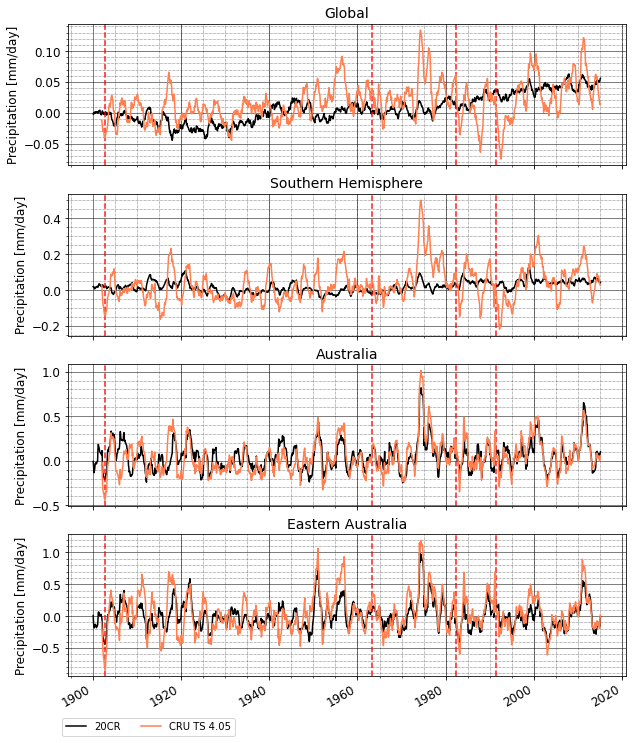

In [48]:
# Monthly rainfall anomalies stacked - rolling mean
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    fplot.timeseries_graph(mmm_mon_Glob_roll12_t.pr, ax = axes[0],  l='20CR')
    fplot.timeseries_graph(mmm_mon_SH_roll12_t.pr, ax = axes[1])
    fplot.timeseries_graph(mmm_mon_Aus_roll12_t.pr, ax = axes[2])
    fplot.timeseries_graph(mmm_mon_EA_roll12_t.pr, ax = axes[3])
    
cru_ts4_llm_glob_roll12.sel(time=slice(start_date, end_date)).plot(ax=axes[0], color='coral',label='CRU TS 4.05')
cru_ts4_llm_SH_roll12.sel(time=slice(start_date, end_date)).plot(ax=axes[1], color='coral')
cru_ts4_llm_Aus_roll12.sel(time=slice(start_date, end_date)).plot(ax=axes[2], color='coral')
cru_ts4_llm_EA_roll12.sel(time=slice(start_date, end_date)).plot(ax=axes[3], color='coral')
    
    
axes[0].set(ylabel= f'Precipitation [mm/day]', title = 'Global') 
axes[1].set(ylabel= f'Precipitation [mm/day]', title = 'Southern Hemisphere')
axes[2].set(ylabel= f'Precipitation [mm/day]', title = 'Australia')
axes[3].set(ylabel= f'Precipitation [mm/day]', title = 'Eastern Australia')

# remove xlabel
axes[0].set_xlabel(None)
axes[1].set_xlabel(None)
axes[2].set_xlabel(None)
axes[3].set_xlabel(None)

# make one legend for all tables (just use last axis to get info)  
handles, labels = axes[0].get_legend_handles_labels()

# first arg to bbox is x second is y (x,y)
fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0.11, 0.05), ncol=3) 

plt.savefig('R_timeseries_mon_pr_cruts_roll12_noP.pdf', dpi=300, bbox_inches='tight')

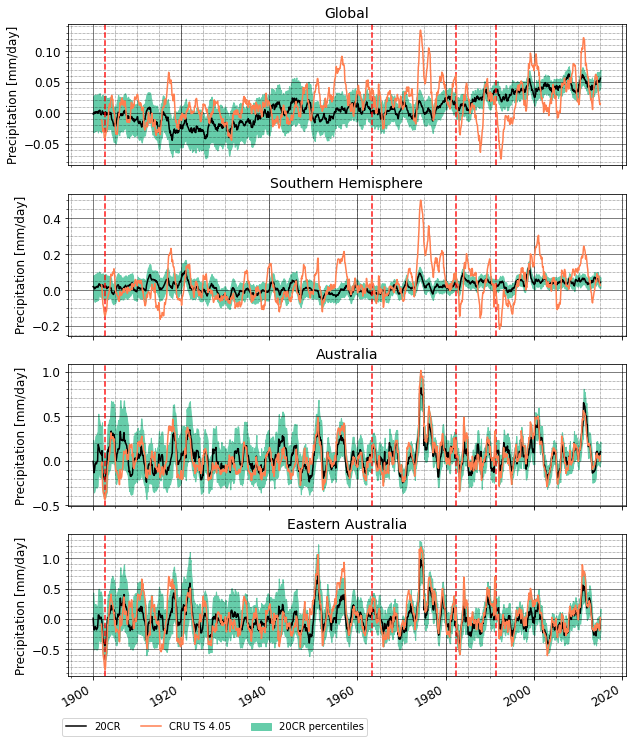

In [40]:
# Monthly rainfall anomalies stacked - rolling mean
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    fplot.timeseries_graph(mmm_mon_Glob_roll12_t.pr, p10_mon_Glob_roll12_t.pr, p90_mon_Glob_roll12_t.pr, ax = axes[0], color='mediumaquamarine', l='20CR', label='20CR percentiles')
    fplot.timeseries_graph(mmm_mon_SH_roll12_t.pr, p10_mon_SH_roll12_t.pr, p90_mon_SH_roll12_t.pr, ax = axes[1], color='mediumaquamarine')
    fplot.timeseries_graph(mmm_mon_Aus_roll12_t.pr, p10_mon_Aus_roll12_t.pr, p90_mon_Aus_roll12_t.pr, ax = axes[2], color='mediumaquamarine')
    fplot.timeseries_graph(mmm_mon_EA_roll12_t.pr, p10_mon_EA_roll12_t.pr, p90_mon_EA_roll12_t.pr, ax = axes[3], color='mediumaquamarine')
    
cru_ts4_llm_glob_roll12.sel(time=slice(start_date, end_date)).plot(ax=axes[0], color='coral',label='CRU TS 4.05')
cru_ts4_llm_SH_roll12.sel(time=slice(start_date, end_date)).plot(ax=axes[1], color='coral')
cru_ts4_llm_Aus_roll12.sel(time=slice(start_date, end_date)).plot(ax=axes[2], color='coral')
cru_ts4_llm_EA_roll12.sel(time=slice(start_date, end_date)).plot(ax=axes[3], color='coral')
    
    
axes[0].set(ylabel= f'Precipitation [mm/day]', title = 'Global') 
axes[1].set(ylabel= f'Precipitation [mm/day]', title = 'Southern Hemisphere')
axes[2].set(ylabel= f'Precipitation [mm/day]', title = 'Australia')
axes[3].set(ylabel= f'Precipitation [mm/day]', title = 'Eastern Australia')

# remove xlabel
axes[0].set_xlabel(None)
axes[1].set_xlabel(None)
axes[2].set_xlabel(None)
axes[3].set_xlabel(None)

# make one legend for all tables (just use last axis to get info)  
handles, labels = axes[0].get_legend_handles_labels()

# first arg to bbox is x second is y (x,y)
fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0.11, 0.05), ncol=3) 

# plt.savefig('R_timeseries_mon_pr_cruts_roll12.png', dpi=300, bbox_inches='tight')

In [ ]:
# Monthly rainfall anomalies stacked - rolling mean
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    fplot.timeseries_graph(mmm_mon_Glob_roll12.pr, p10_mon_Glob_roll12.pr, p90_mon_Glob_roll12.pr, ax = axes[0], color='mediumaquamarine')
    fplot.timeseries_graph(mmm_mon_SH_roll12.pr, p10_mon_SH_roll12.pr, p90_mon_SH_roll12.pr, ax = axes[1], color='mediumaquamarine')
    fplot.timeseries_graph(mmm_mon_Aus_roll12.pr, p10_mon_Aus_roll12.pr, p90_mon_Aus_roll12.pr, ax = axes[2], color='mediumaquamarine')
    fplot.timeseries_graph(mmm_mon_EA_roll12.pr, p10_mon_EA_roll12.pr, p90_mon_EA_roll12.pr, ax = axes[3], color='mediumaquamarine')

    
axes[0].set(ylabel= f'Precipitation [mm/day]', title = 'Global') 
axes[1].set(ylabel= f'Precipitation [mm/day]', title = 'Southern Hemisphere')
axes[2].set(ylabel= f'Precipitation [mm/day]', title = 'Australia')
axes[3].set(ylabel= f'Precipitation [mm/day]', title = 'Eastern Australia')

#fig.suptitle('Time series of temperature anomalies', size=16)

#fig.tight_layout() # makes titles overlap, but is meant to stops things from overlapping and makes the figure more compact

plt.savefig('R_timeseries_mon_pr_roll12.png', dpi=300, bbox_inches='tight')

In [34]:
# rolling mean version
K_mmm_Glob_roll6 = mmm_mon_Glob_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_SH_roll6 = mmm_mon_SH_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_Aus_roll6 = mmm_mon_Aus_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_EA_roll6 = mmm_mon_EA_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p10_Glob_roll6 = p10_mon_Glob_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_SH_roll6 = p10_mon_SH_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_Aus_roll6 = p10_mon_Aus_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_EA_roll6 = p10_mon_EA_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p90_Glob_roll6 = p90_mon_Glob_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_SH_roll6 = p90_mon_SH_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_Aus_roll6 = p90_mon_Aus_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_EA_roll6 = p90_mon_EA_roll6.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

In [35]:
# rolling mean zoomed in for Krakatoa time period
# 3 month rolling mean and precentiles
K_mmm_Glob_roll3 = mmm_mon_Glob_roll3.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_Aus_roll3 = mmm_mon_Aus_roll3.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p10_Glob_roll3 = p10_mon_Glob_roll3.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_Aus_roll3 = p10_mon_Aus_roll3.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p90_Glob_roll3 = p90_mon_Glob_roll3.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_Aus_roll3 = p90_mon_Aus_roll3.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

# 12 month rolling mean and precentiles
K_mmm_Glob_roll12 = mmm_mon_Glob_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_SH_roll12 = mmm_mon_SH_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_Aus_roll12 = mmm_mon_Aus_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_EA_roll12 = mmm_mon_EA_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p10_Glob_roll12 = p10_mon_Glob_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_SH_roll12 = p10_mon_SH_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_Aus_roll12 = p10_mon_Aus_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_EA_roll12 = p10_mon_EA_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p90_Glob_roll12 = p90_mon_Glob_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_SH_roll12 = p90_mon_SH_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_Aus_roll12 = p90_mon_Aus_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_EA_roll12 = p90_mon_EA_roll12.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

# 3 month rolling mean and precentiles
K_mmm_Glob_roll24 = mmm_mon_Glob_roll24.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_Aus_roll24 = mmm_mon_Aus_roll24.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p10_Glob_roll24 = p10_mon_Glob_roll24.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_Aus_roll24 = p10_mon_Aus_roll24.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p90_Glob_roll24 = p90_mon_Glob_roll24.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_Aus_roll24 = p90_mon_Aus_roll24.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))


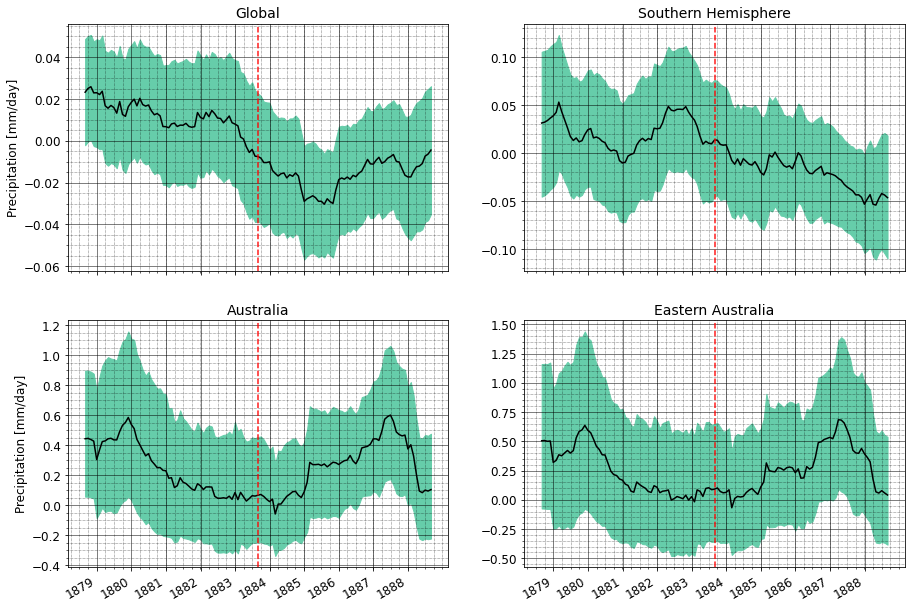

In [36]:
# Monthly rainfall anomalies for Krakatoa
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10)) # make a figure

# make subplots for each region
fplot.timeseries_graph(K_mmm_Glob_roll12.pr, K_p10_Glob_roll12.pr, K_p90_Glob_roll12.pr, ax = axes[0,0], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_SH_roll12.pr, K_p10_SH_roll12.pr, K_p90_SH_roll12.pr, ax = axes[0,1], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_Aus_roll12.pr, K_p10_Aus_roll12.pr, K_p90_Aus_roll12.pr, ax = axes[1,0], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_EA_roll12.pr, K_p10_EA_roll12.pr, K_p90_EA_roll12.pr, ax = axes[1,1], color='mediumaquamarine')

# set axis labels and subplot titles
axes[0,0].set(ylabel= f'Precipitation [mm/day]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel= f'Precipitation [mm/day]', title = 'Australia')
axes[1,1].set(title = 'Eastern Australia')

# set the axis ticks to be monthly 
axes[0,0].set_xticks(years)
axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('R_K_timeseries_mon_pr_roll12.png', dpi=300, bbox_inches='tight')

## stats

### standard deviation for significance

In [34]:
func=reload(func)

In [35]:
# define array with region name, and then corresponding time series 
regions = ['Glob','SH','Aus','EA']
time_series = [mmm_mon_Glob_roll12.pr, mmm_mon_SH_roll12.pr, mmm_mon_Aus_roll12.pr, mmm_mon_EA_roll12.pr]

data = {r: d for r, d in zip(regions, time_series)}

In [36]:
# calculate and print statistical significance of 2 standard deviations
func.sig_2std_vals(data, var='precipitation')

Significance of 2 standard deviations of precipitation signal on each spatial scale is:
Glob: 0.022 mm/day
SH: 0.035 mm/day
Aus: 0.404 mm/day
EA: 0.511 mm/day


### maximum

In [39]:
time_series = [K_mmm_Aus_roll12.pr, K_mmm_EA_roll12.pr]

K_data = {r: d for r, d in zip(regions, time_series)}

In [41]:
func.max_vals(K_data, var='precipitation')

Maximum value of roll12 precipitation signal on each spatial scale is:
Glob: 0.601 mm/day in Jun 1887
SH: 0.685 mm/day in Mar 1887


### minimum

In [ ]:
# calculate the minimum value of the mmm for each spatial region
K_mmm_Glob_roll12_min = K_mmm_Glob_roll12.min()
K_mmm_SH_roll12_min = K_mmm_SH_roll12.sel(time=slice('1883-01','1886-01')).min()
K_mmm_SH_roll12_min1 = K_mmm_SH_roll12.min()
K_mmm_Aus_roll12_min = K_mmm_Aus_roll12.min()
K_mmm_EA_roll12_min = K_mmm_EA_roll12.min()
min_date_Glob = func.min_date(K_mmm_Glob_roll12.pr, K_mmm_Glob_roll12_min.pr).dt.strftime("%b %Y")
min_date_SH = func.min_date(K_mmm_SH_roll12.pr, K_mmm_SH_roll12_min.pr).dt.strftime("%b %Y")
min_date_SH1 = func.min_date(K_mmm_SH_roll12.pr, K_mmm_SH_roll12_min1.pr).dt.strftime("%b %Y")
min_date_Aus = func.min_date(K_mmm_Aus_roll12.pr, K_mmm_Aus_roll12_min.pr).dt.strftime("%b %Y")
min_date_EA = func.min_date(K_mmm_EA_roll12.pr, K_mmm_EA_roll12_min.pr).dt.strftime("%b %Y")

In [44]:
print('Minimum value of roll12 precipitation signal on each spatial scale is:\n Global:', 
      K_mmm_Glob_roll12_min.pr.values.round(decimals=2), f'in {min_date_Glob.data}', '\n SH:', 
      K_mmm_SH_roll12_min1.pr.values.round(decimals=2), f'in {min_date_SH.data},', 
      K_mmm_SH_roll12_min.pr.values.round(decimals=2), f'in {min_date_SH1.data}','\n Aus:', 
      K_mmm_Aus_roll12_min.pr.values.round(decimals=2), f'in {min_date_Aus.data}','\n EA:', 
      K_mmm_EA_roll12_min.pr.values.round(decimals=2), f'in {min_date_EA.data}')

Minimum value of roll12 precipitation signal on each spatial scale is:
 Global: -0.03 in Jul 1885 
 SH: -0.05 in Jan 1885, -0.02 in Apr 1888 
 Aus: -0.06 in Feb 1884 
 EA: -0.07 in Feb 1884


### correlation

In [45]:
# calculate the correlation coefficient using different methods for entire overlapping time period
print(scipy.stats.pearsonr(cru_ts4_llm_glob.sel(time=slice('1901-01','2015-01')), mmm_mon_Glob.pr.sel(time=slice('1901-01','2015-01'))))#[0]    # Pearson's r

(0.15526168474775778, 7.718878788378373e-09)


In [46]:
# calculate the correlation coefficient using different methods for entire overlapping time period
print(scipy.stats.pearsonr(cru_ts4_llm_SH.sel(time=slice('1901-01','2015-01')), mmm_mon_SH.pr.sel(time=slice('1901-01','2015-01'))))#[0]    # Pearson's r

(0.21851901914515803, 2.9140463010684664e-16)


In [49]:
# calculate the correlation coefficient using different methods for entire overlapping time period
print(scipy.stats.pearsonr(cru_ts4_llm_SH.sel(time=slice('1901-01','2015-01')), mmm_mon_SH_land.pr.sel(time=slice('1901-01','2015-01'))))#[0]    # Pearson's r

(0.608595270537876, 1.6421304931590583e-139)


In [47]:
# calculate the correlation coefficient using different methods for entire overlapping time period
print(scipy.stats.pearsonr(cru_ts4_llm_Aus.sel(time=slice('1901-01','2015-01')), mmm_mon_Aus.pr.sel(time=slice('1901-01','2015-01'))))#[0]    # Pearson's r

(0.8178790944824205, 0.0)


In [48]:
# calculate the correlation coefficient using different methods for entire overlapping time period
print(scipy.stats.pearsonr(cru_ts4_llm_EA.sel(time=slice('1901-01','2015-01')), mmm_mon_EA.pr.sel(time=slice('1901-01','2015-01'))))#[0]    # Pearson's r

(0.8012859727994005, 2.8837786074745145e-307)


In [ ]:
# Monthly precipitation anomalies for Krakatoa
fig, axes = plt.subplots(2, 4, sharex=True, figsize=(15,8)) # make a figure

# make subplots for each region
fplot.timeseries_graph(K_mmm_Glob_roll3.pr, K_p10_Glob_roll3.pr, K_p90_Glob_roll3.pr, ax = axes[0,0], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_Glob_roll6.pr, K_p10_Glob_roll6.pr, K_p90_Glob_roll6.pr, ax = axes[0,1], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_Glob_roll12.pr, K_p10_Glob_roll12.pr, K_p90_Glob_roll12.pr, ax = axes[0,2], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_Glob_roll24.pr, K_p10_Glob_roll24.pr, K_p90_Glob_roll24.pr, ax = axes[0,3], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_Aus_roll3.pr, K_p10_Aus_roll3.pr, K_p90_Aus_roll3.pr, ax = axes[1,0], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_Aus_roll6.pr, K_p10_Aus_roll6.pr, K_p90_Aus_roll6.pr, ax = axes[1,1], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_Aus_roll12.pr, K_p10_Aus_roll12.pr, K_p90_Aus_roll12.pr, ax = axes[1,2], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_Aus_roll24.pr, K_p10_Aus_roll24.pr, K_p90_Aus_roll24.pr, ax = axes[1,3], color='mediumaquamarine')

# set axis labels and subplot titles
axes[0,0].set(ylabel= f'Precipitation anomaly [mm/day]', title = 'Global 3-month rolling mean') 
axes[0,1].set(title = 'Global 6-month rolling mean')
axes[0,2].set(title = 'Global 12-month rolling mean')
axes[0,3].set(title = 'Global 24-month rolling mean')
axes[1,0].set(ylabel= f'Precipitation anomaly [mm/day]', title = 'Australia 3-month rolling mean')
axes[1,1].set(title = 'Australia 6-month rolling mean')
axes[1,2].set(title = 'Australia 12-month rolling mean')
axes[1,3].set(title = 'Australia 24-month rolling mean')



# set the axis ticks to be monthly 
# axes[0,0].set_xticks(years)
# axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('R_K_timeseries_mon_pr_rolling3-6-12-24.png', dpi=300, bbox_inches='tight')

In [ ]:
# Monthly precipitation anomalies for Krakatoa
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10)) # make a figure

# make subplots for each region
fplot.timeseries_graph(K_mmm_Glob_roll6.pr, K_p10_Glob_roll6.pr, K_p90_Glob_roll6.pr, ax = axes[0,0], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_SH_roll6.pr, K_p10_SH_roll6.pr, K_p90_SH_roll6.pr, ax = axes[0,1], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_Aus_roll6.pr, K_p10_Aus_roll6.pr, K_p90_Aus_roll6.pr, ax = axes[1,0], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_EA_roll6.pr, K_p10_EA_roll6.pr, K_p90_EA_roll6.pr, ax = axes[1,1], color='mediumaquamarine')

# set axis labels and subplot titles
axes[0,0].set(ylabel= f'Rainfall anomaly [mm/day]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel= f'Rainfall anomaly [mm/day]', title = 'Australia')
axes[1,1].set(title = 'Eastern Australia')

# set the axis ticks to be monthly 
axes[0,0].set_xticks(years)
axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('R_K_timeseries_mon_pr_rolling6.png', dpi=300, bbox_inches='tight')

### vcalues for table

In [75]:
time_array = ['1884-02', '1884-08', '1885-02', '1885-08', '1886-02', '1886-08']

# define array with region name, and then corresponding time series 
regions = ['Glob', 'SH', 'Aus','EA']
# composite signal 
time_series_pr = [K_mmm_Glob_roll12.pr, K_mmm_SH_roll12.pr, K_mmm_Aus_roll12.pr, K_mmm_EA_roll12.pr]

data = {r: d for r, d in zip(regions, time_series_pr)}

# print in mm/day
func.vals_monthly(data, 'precipitation', time_array)

Value of precipitation signal on each spatial scale is:
Glob:
1884-02 [-0.016] mm/day
1884-08 [-0.017] mm/day
1885-02 [-0.027] mm/day
1885-08 [-0.028] mm/day
1886-02 [-0.018] mm/day
1886-08 [-0.014] mm/day
SH:
1884-02 [-0.008] mm/day
1884-08 [-0.012] mm/day
1885-02 [-0.016] mm/day
1885-08 [-0.013] mm/day
1886-02 [-0.003] mm/day
1886-08 [-0.016] mm/day
Aus:
1884-02 [-0.059] mm/day
1884-08 [0.089] mm/day
1885-02 [0.286] mm/day
1885-08 [0.256] mm/day
1886-02 [0.297] mm/day
1886-08 [0.382] mm/day
EA:
1884-02 [-0.068] mm/day
1884-08 [0.083] mm/day
1885-02 [0.315] mm/day
1885-08 [0.253] mm/day
1886-02 [0.185] mm/day
1886-08 [0.489] mm/day


In [45]:
# define array with region name, and then corresponding time series 
regions = ['Glob', 'SH', 'Aus','EA']
# composite signal 
time_series_pr = [K_mmm_Glob_roll12.pr, K_mmm_SH_roll12.pr, K_mmm_Aus_roll12.pr, K_mmm_EA_roll12.pr]

data = {r: d for r, d in zip(regions, time_series_pr)}

In [46]:
# rainfall values in mm/day
func.vals_seasonal(data, 'precipitation')

Value of precipitation signal on each spatial scale is:
Glob:
DJF 1883: 0.006 mm/day
DJF 1884: -0.013 mm/day
DJF 1885: -0.028 mm/day
DJF 1886: -0.018 mm/day
JJA 1883: -0.006 mm/day
JJA 1884: -0.017 mm/day
JJA 1885: -0.029 mm/day
JJA 1886: -0.016 mm/day
SH:
DJF 1883: 0.033 mm/day
DJF 1884: 0.001 mm/day
DJF 1885: -0.02 mm/day
DJF 1886: -0.004 mm/day
JJA 1883: 0.011 mm/day
JJA 1884: -0.009 mm/day
JJA 1885: -0.009 mm/day
JJA 1886: -0.019 mm/day
Aus:
DJF 1883: 0.069 mm/day
DJF 1884: 0.001 mm/day
DJF 1885: 0.176 mm/day
DJF 1886: 0.285 mm/day
JJA 1883: 0.063 mm/day
JJA 1884: 0.074 mm/day
JJA 1885: 0.265 mm/day
JJA 1886: 0.324 mm/day
EA:
DJF 1883: 0.032 mm/day
DJF 1884: 0.027 mm/day
DJF 1885: 0.192 mm/day
DJF 1886: 0.227 mm/day
JJA 1883: 0.094 mm/day
JJA 1884: 0.058 mm/day
JJA 1885: 0.266 mm/day
JJA 1886: 0.377 mm/day


In [78]:
# define array with region name, and then corresponding time series 
regions = ['Glob', 'SH', 'Aus','EA']
# composite signal 
time_series_pr = [K_mmm_Glob_roll12.pr*30.4167, K_mmm_SH_roll12.pr*30.4167, K_mmm_Aus_roll12.pr*30.4167, 
                  K_mmm_EA_roll12.pr*30.4167]
data = {r: d for r, d in zip(regions, time_series_pr)}

# print in mm/month
func.vals_monthly(data, dates = time_array)

Value of  signal on each spatial scale is:
Glob:
1884-02 [-0.474]
1884-08 [-0.515]
1885-02 [-0.823]
1885-08 [-0.843]
1886-02 [-0.558]
1886-08 [-0.44]
SH:
1884-02 [-0.232]
1884-08 [-0.352]
1885-02 [-0.499]
1885-08 [-0.394]
1886-02 [-0.083]
1886-08 [-0.486]
Aus:
1884-02 [-1.802]
1884-08 [2.72]
1885-02 [8.689]
1885-08 [7.777]
1886-02 [9.023]
1886-08 [11.613]
EA:
1884-02 [-2.067]
1884-08 [2.531]
1885-02 [9.589]
1885-08 [7.709]
1886-02 [5.616]
1886-08 [14.872]


In [43]:
# define array with region name, and then corresponding time series 
regions = ['Glob', 'SH', 'Aus','EA']
# rainfall data in mm/month
time_series_pr = [K_mmm_Glob_roll12.pr*30.4167, K_mmm_SH_roll12.pr*30.4167, K_mmm_Aus_roll12.pr*30.4167, 
                  K_mmm_EA_roll12.pr*30.4167]

data = {r: d for r, d in zip(regions, time_series_pr)}

In [44]:
# rainfall values in mm/month
func.vals_seasonal(data)

Value of  signal on each spatial scale is:
Glob:
DJF 1883: 0.172
DJF 1884: -0.404
DJF 1885: -0.849
DJF 1886: -0.554
JJA 1883: -0.192
JJA 1884: -0.516
JJA 1885: -0.881
JJA 1886: -0.477
SH:
DJF 1883: 1.017
DJF 1884: 0.017
DJF 1885: -0.6
DJF 1886: -0.111
JJA 1883: 0.343
JJA 1884: -0.264
JJA 1885: -0.263
JJA 1886: -0.563
Aus:
DJF 1883: 2.089
DJF 1884: 0.043
DJF 1885: 5.349
DJF 1886: 8.656
JJA 1883: 1.922
JJA 1884: 2.244
JJA 1885: 8.06
JJA 1886: 9.854
EA:
DJF 1883: 0.966
DJF 1884: 0.827
DJF 1885: 5.853
DJF 1886: 6.901
JJA 1883: 2.848
JJA 1884: 1.763
JJA 1885: 8.094
JJA 1886: 11.459
